# Explore the data

The intention of this notebook is to explore the data and try out the methods of the developed library.

## Imports and basic definitions

In [1]:
import itertools
import math
import os
import pickle

import networkx as nx
import numpy as np
from rfa import *

NA = NetworkAnalyzer
import matplotlib.pyplot as plt

output_dir: str = "output/"
os.makedirs(output_dir, exist_ok=True)

reader = WikiDataReader("data/original.txt")

## Full Graph

In [2]:
graph_maker = WikiDataGraphMaker()
graph_maker.data = reader.data
g = graph_maker.make()

In [3]:

# basic statistics
print("number_of_nodes = ", NA.number_of_nodes(g))
print("number_of_edges = ", NA.number_of_edges(g))
print(
    "weakely_connected_components = ",
    NA.weakely_connected_components(g)["number_of_connected_componets"],
)
print("has cycle = ", NA.has_cycle(g))

number_of_nodes =  11256
number_of_edges =  184546
weakely_connected_components =  1
has cycle =  True


In [4]:
def count_in_degree_equals_out_degree(dg: nx.MultiDiGraph) -> float:
    number_of_equal_degrees: int = 0
    for node in dg.nodes():
        if dg.in_degree(node) == dg.out_degree(node):
            number_of_equal_degrees += 1
    return number_of_equal_degrees / dg.number_of_nodes()

100 * count_in_degree_equals_out_degree(g)

0.13326226012793177

In [5]:
def count_reverse_arc_fraction(dg: nx.MultiDiGraph) -> float:
    number_of_reverse_arcs_present: int = 0
    for arc in dg.edges():
        head, tail = arc
        if dg.has_edge(tail, head):
            number_of_reverse_arcs_present += 1
    return number_of_reverse_arcs_present / dg.number_of_edges()

count_reverse_arc_fraction(g)

0.07558549088032251

## Gephi

Export full graph to Gephi (it takes some time...)

In [21]:
gephi_file: str = os.path.join(output_dir, "gephi.gexf")
NA.export_to_gephi(g, gephi_file)
print(f"Gephi file '{gephi_file} written")

Gephi file 'output/gephi.gexf written


## Analysis of the votes per year

Analyse the general behavior of people in different years.

### Number of votes per year

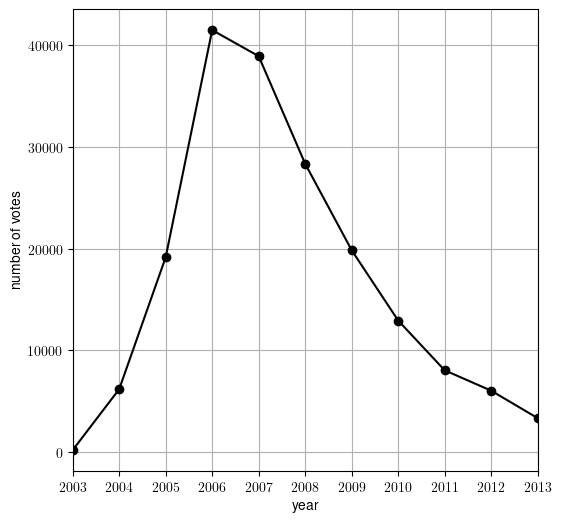

In [22]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot(
    ax,
    lambda g: g.number_of_edges(),
    y_label="number of votes",
)
fig.savefig(os.path.join(output_dir, "number_of_votes_per_year.png"))
plt.close(fig)
fig

### Quartiles

They tell us nothing...

Plot the quartiles per year. We want to see how people's behavior changed over time.

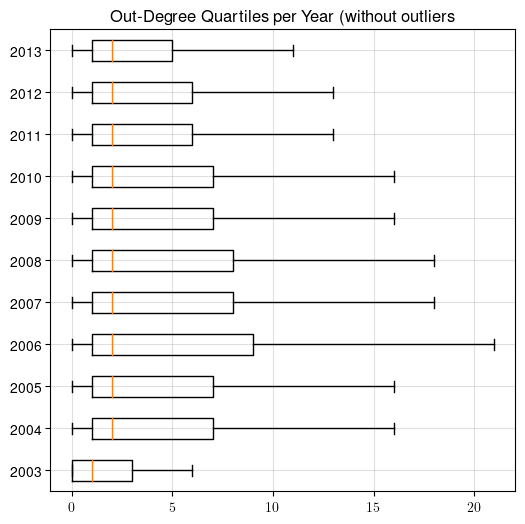

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.OUT,
    outliers=False,
)
fig.savefig(os.path.join(output_dir, "quartiles_out.png"))
plt.close(fig)
fig

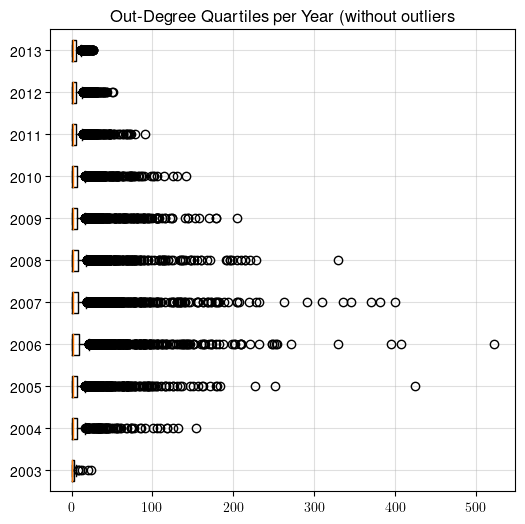

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.OUT,
    outliers=True,
)
fig.savefig(os.path.join(output_dir, "quartiles_out_with_outliers.png"))
plt.close(fig)
fig

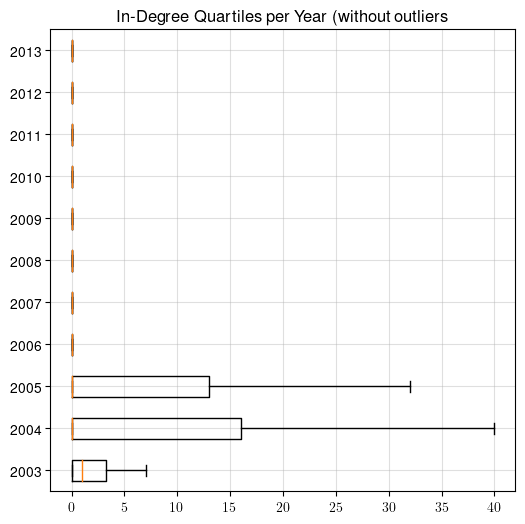

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.IN,
    outliers=False,
)
fig.savefig(os.path.join(output_dir, "quartiles_in.png"))
plt.close(fig)
fig

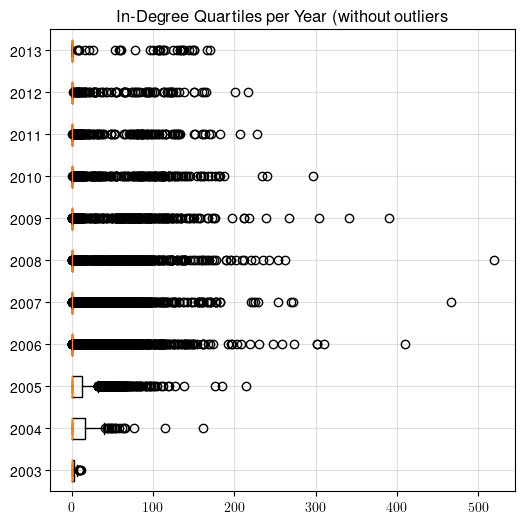

In [26]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
gpy = GraphPerYear(reader.data)
gpy.plot_quartiles(
    ax=ax,
    degree_type=DegreeType.IN,
    outliers=True,
)
fig.savefig(os.path.join(output_dir, "quartiles_in_with_outliers.png"))
plt.close(fig)
fig

### Analysis of the Quartiles

I cannot conclude much from it, there are way too many outliers...

Perhaps one could say that many people voted, but they voted in a very few and selected people. I mean, it is discussable if that is true, and how much true that is given the data...

## Cummulative Degree Distribution

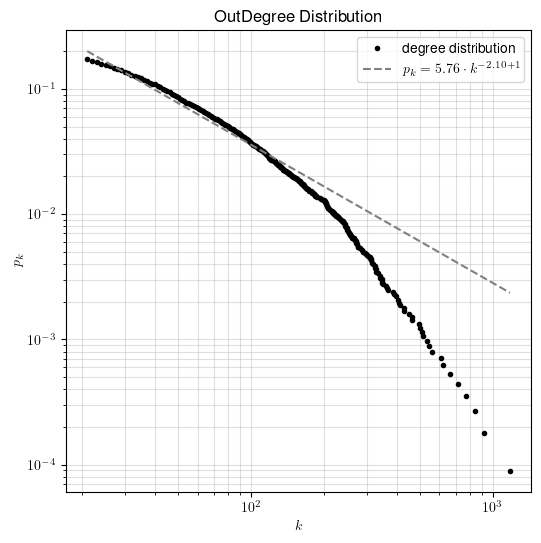

In [27]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cdd = CummulativeDegreeDistribution(g, DegreeType.OUT)
cdd.plot(ax)
fig.savefig(os.path.join(output_dir, cdd.file_name))
plt.close(fig)
fig

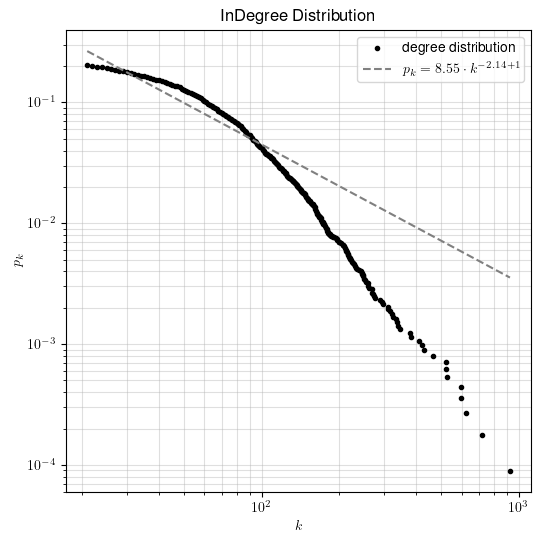

In [28]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cdd = CummulativeDegreeDistribution(g, DegreeType.IN)
cdd.plot(ax)
fig.savefig(os.path.join(output_dir, cdd.file_name))
plt.close(fig)
fig

## Analysis of the degree distribution

It is not a power-law distribution. How do I know? Lack of hubs, and the curve fit is poor. There is an interesting conclusion about this: it is not a network governed by preferential attachment.

## Robustness to Attack

In [55]:
with open("output/robustness.pkl", "rb") as file:
    r = pickle.load(file)


In [60]:
k = np.array([
    g.degree(n)
    for n in g.nodes()
])

k_avr = np.average(k)
k_std = np.std(k)

f_network = 1 - (1 / ((k_avr / k_std) - 1))
f_random_network = 1 - (1 / k_avr)

print(f"theoretical critical threshold = {f_network}")
print(f"critical threshold for random networks = {f_random_network}")
print(f"network has enhanced robustness? {f_network > f_random_network}")


theoretical critical threshold = 2.8329946057386284
critical threshold for random networks = 0.9695035384131869
network has enhanced robustness? True


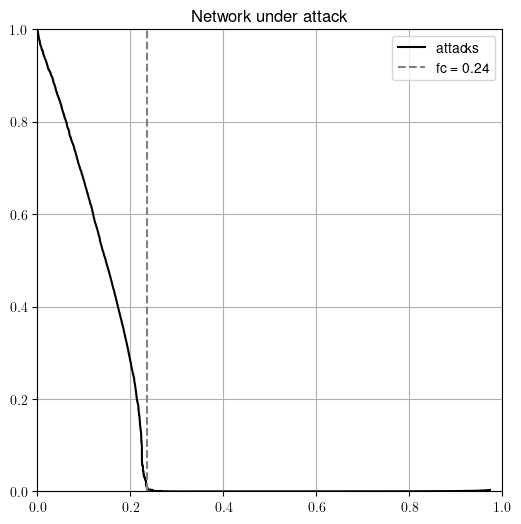

In [62]:
fs = np.array(r.fs[:-300])
ps = np.array(r.ps[:-300])
for i in range(len(ps)):
    if ps[i] < 0.01:
        break
p_critical = ps[i]
f_critical = fs[i]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(r.fs[:-300], r.ps[:-300], 'k', label="attacks")
ax.vlines(f_critical, 0, 1, color='gray', linestyles='--', label="fc = {:.2f}".format(f_critical))
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title("Network under attack")
ax.legend(loc="best")
fig.savefig(os.path.join(output_dir, "robustness.png"))
plt.close(fig)
fig

In [6]:
data_on_years = GraphPerYear(
    reader.data,
    build_robustness = True
)
with open(os.path.join(output_dir, "per_year.pkl"), "wb") as file:
    pickle.dump(data_on_years, file)

91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658
657
656
655
654
653
652
651
650
649
648
647
646
645
644
643
642
641
640
639
638
637
636
635
634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532


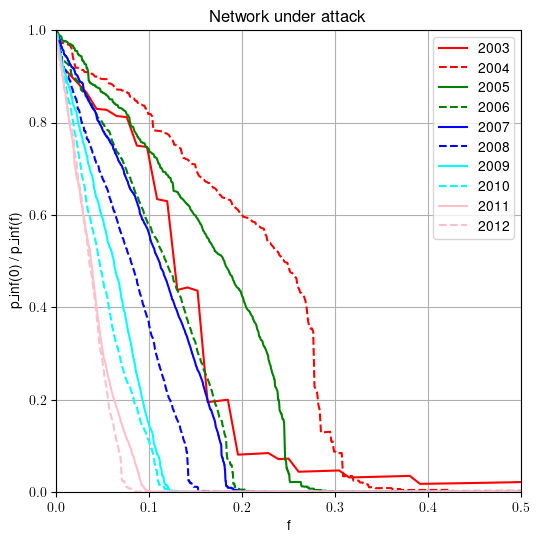

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

with open(os.path.join(output_dir, "per_year.pkl"), "rb") as file:
    data = pickle.load(file)

tail_cut = [math.ceil(0.15 * len(vs.ps)) for vs in data.robustness.values()]
colors = ['red', 'green', 'blue', 'cyan', 'pink']
linestyle = ['-', '--']
cl = itertools.product(colors, linestyle)
for year, r, tc, clp in zip(data.robustness.keys(), data.robustness.values(), tail_cut, cl):
    fs, ps = r.fs, r.ps
    ax.plot(fs[:-tc], ps[:-tc], color=clp[0], linestyle=clp[1], label=f"{year}")
ax.grid(True)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 1])
ax.set_title("Network under attack")
ax.set_xlabel("f")
ax.set_ylabel("p_inf(0) / p_inf(f)")
ax.legend(loc="best")
fig.savefig(os.path.join(output_dir, "robustness_per_year.png"))
plt.close(fig)
fig